In [34]:
## imports here !!!
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.impute import SimpleImputer
#pd.set_option('display.float_format', lambda x: '%f' % x)

In [2]:
'''
Importing data
'''
train_data= pd.read_csv('iith_foml_2020_train.csv')
train = pd.DataFrame(train_data)   ### Raw data
test_data= pd.read_csv('iith_foml_2020_test.csv')
test = pd.DataFrame(test_data)    ### Raw data
test.head()


#test.describe()

,Feature 1 (Discrete),Feature 2 (Discrete),Feature 3 (Discrete),Feature 4 (Discrete),Feature 5 (Discrete),Feature 6 (Discrete),Feature 7 (Discrete),Feature 8 (Discrete),Feature 9,Feature 10,...,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19 (Discrete),Feature 20 (Discrete),Feature 21 (Discrete),Feature 22 (Discrete),Feature 23 (Discrete),Feature 24
0,146,12,42,14,7,1,1,1,118.004,35693.5,...,4200.3,1900.1,NaN,NaN,44,12,2,42,146,37384.5
1,35,0,12,5,0,0,1,0,0.001,471.5,...,531.4,NaN,NaN,NaN,17,6,8,0,35,41465.1
2,1018,8,259,2,1,1,1,1,NaN,35774.5,...,5514.2,NaN,NaN,15.04,1,1,3,20,1018,37826.2
3,383,7,117,5,1,1,1,1,53.002,34094.1,...,3358.4,1100.2,14000.001,15.04,101,6,3,20,383,40277.3
4,1216,7,40,5,2,0,1,4,0.005,1471.3,...,225.1,NaN,NaN,3.02,276,6,7,43,1221,28419.5


### Analysis of missing values..

In [3]:

def Summarise_missing_values(new_data):
    cols_with_missing = (col for col in new_data.columns if new_data[col].isnull().any())
    num_missing = (new_data[cols_with_missing].isnull()).sum()
    print("Missing values in percent")
    # report the results
    print(round((num_missing/new_data.shape[0]) * 100, 2))
    print("######################################################################################") 

print("****************************For TRAIN data")
Summarise_missing_values(train.copy())
print("****************************For Test data")
Summarise_missing_values(test.copy())


****************************For TRAIN data
Missing values in percent
Feature 9      1.41
Feature 10     0.10
Feature 11     0.10
Feature 12     0.10
Feature 13     0.10
Feature 14     0.10
Feature 15     7.24
Feature 16    67.30
Feature 17    54.93
Feature 18    33.20
Feature 24     0.10
dtype: float64
######################################################################################
****************************For Test data
Missing values in percent
Feature 9      0.94
Feature 14     0.47
Feature 15     7.28
Feature 16    65.49
Feature 17    52.82
Feature 18    26.76
dtype: float64
######################################################################################


In [6]:

def imputing_missing_values(df):
    data = df.to_numpy()
    # define the imputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer  = imputer.fit(data)
    # transform the dataset
    transformed_values = imputer.transform(data)
    imputed_data = pd.DataFrame(data = transformed_values,columns = df.columns) 
    return imputed_data


imputed_train = imputing_missing_values(train)
imputed_test = imputing_missing_values(test)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
imputed_train.describe()


,Feature 1 (Discrete),Feature 2 (Discrete),Feature 3 (Discrete),Feature 4 (Discrete),Feature 5 (Discrete),Feature 6 (Discrete),Feature 7 (Discrete),Feature 8 (Discrete),Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19 (Discrete),Feature 20 (Discrete),Feature 21 (Discrete),Feature 22 (Discrete),Feature 23 (Discrete),Feature 24,Target Variable (Discrete)
count,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000
mean,708.187,5.899,159.564,11.651,2.624,0.581,2.041,1.643,6.113,14527.974,16057.137,0.020,50.015,642.128,2042.520,1329.780,3814.421,2061.807,94.004,7.660,4.777,45.635,709.334,34605.373,1.706
std,405.826,7.563,106.706,15.159,2.652,0.747,2.550,1.532,54.273,16438.642,18967.035,0.111,41.766,659.089,2201.290,722.723,3117.065,7582.518,90.311,10.658,4.774,36.070,407.361,6117.763,2.417
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-177.116,200.400,322.500,0.000,0.001,7.014,0.200,6.500,4.055,0.270,0.000,0.000,0.000,0.000,0.000,7530.300,0.000
25%,357.750,0.000,66.250,2.000,1.000,0.000,1.000,0.000,0.001,621.300,683.775,0.000,0.094,97.702,207.150,1329.780,1615.004,8.030,12.000,1.000,1.000,14.250,357.750,28378.375,0.250
50%,705.000,3.000,146.000,5.000,2.000,0.000,1.000,1.000,0.003,1409.200,1415.150,0.001,54.904,114.101,1480.450,1329.780,3814.421,15.020,73.500,2.000,3.000,39.000,705.000,37264.750,1.000
75%,1064.500,8.000,239.000,15.000,3.000,1.000,1.000,3.000,0.005,35770.400,35794.500,0.002,97.470,1436.083,3200.375,1329.780,3814.421,2061.807,152.000,12.000,7.000,64.000,1064.500,40038.150,2.000
max,1412.000,46.000,386.000,80.000,14.000,4.000,19.000,7.000,328.502,37778.400,156833.300,0.864,143.402,4032.863,18000.300,10000.400,20000.005,44118.010,318.000,58.000,23.000,155.000,1417.000,41634.300,17.000


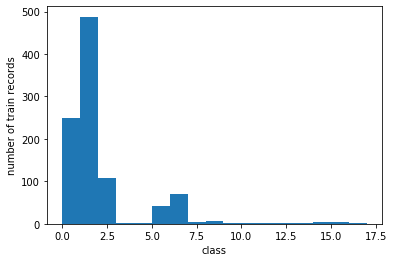

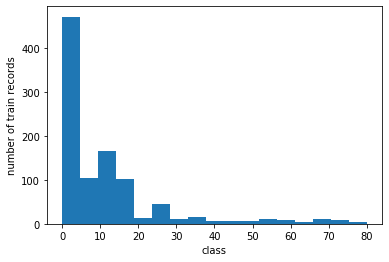

In [12]:
plt.hist(imputed_train['Target Variable (Discrete)'].values,bins = 17)
plt.xlabel('class')
plt.ylabel('number of train records')
plt.show()

plt.hist(imputed_train['Feature 4 (Discrete)'].values,bins = 17)
plt.xlabel('class')
plt.ylabel('number of train records')
plt.show()



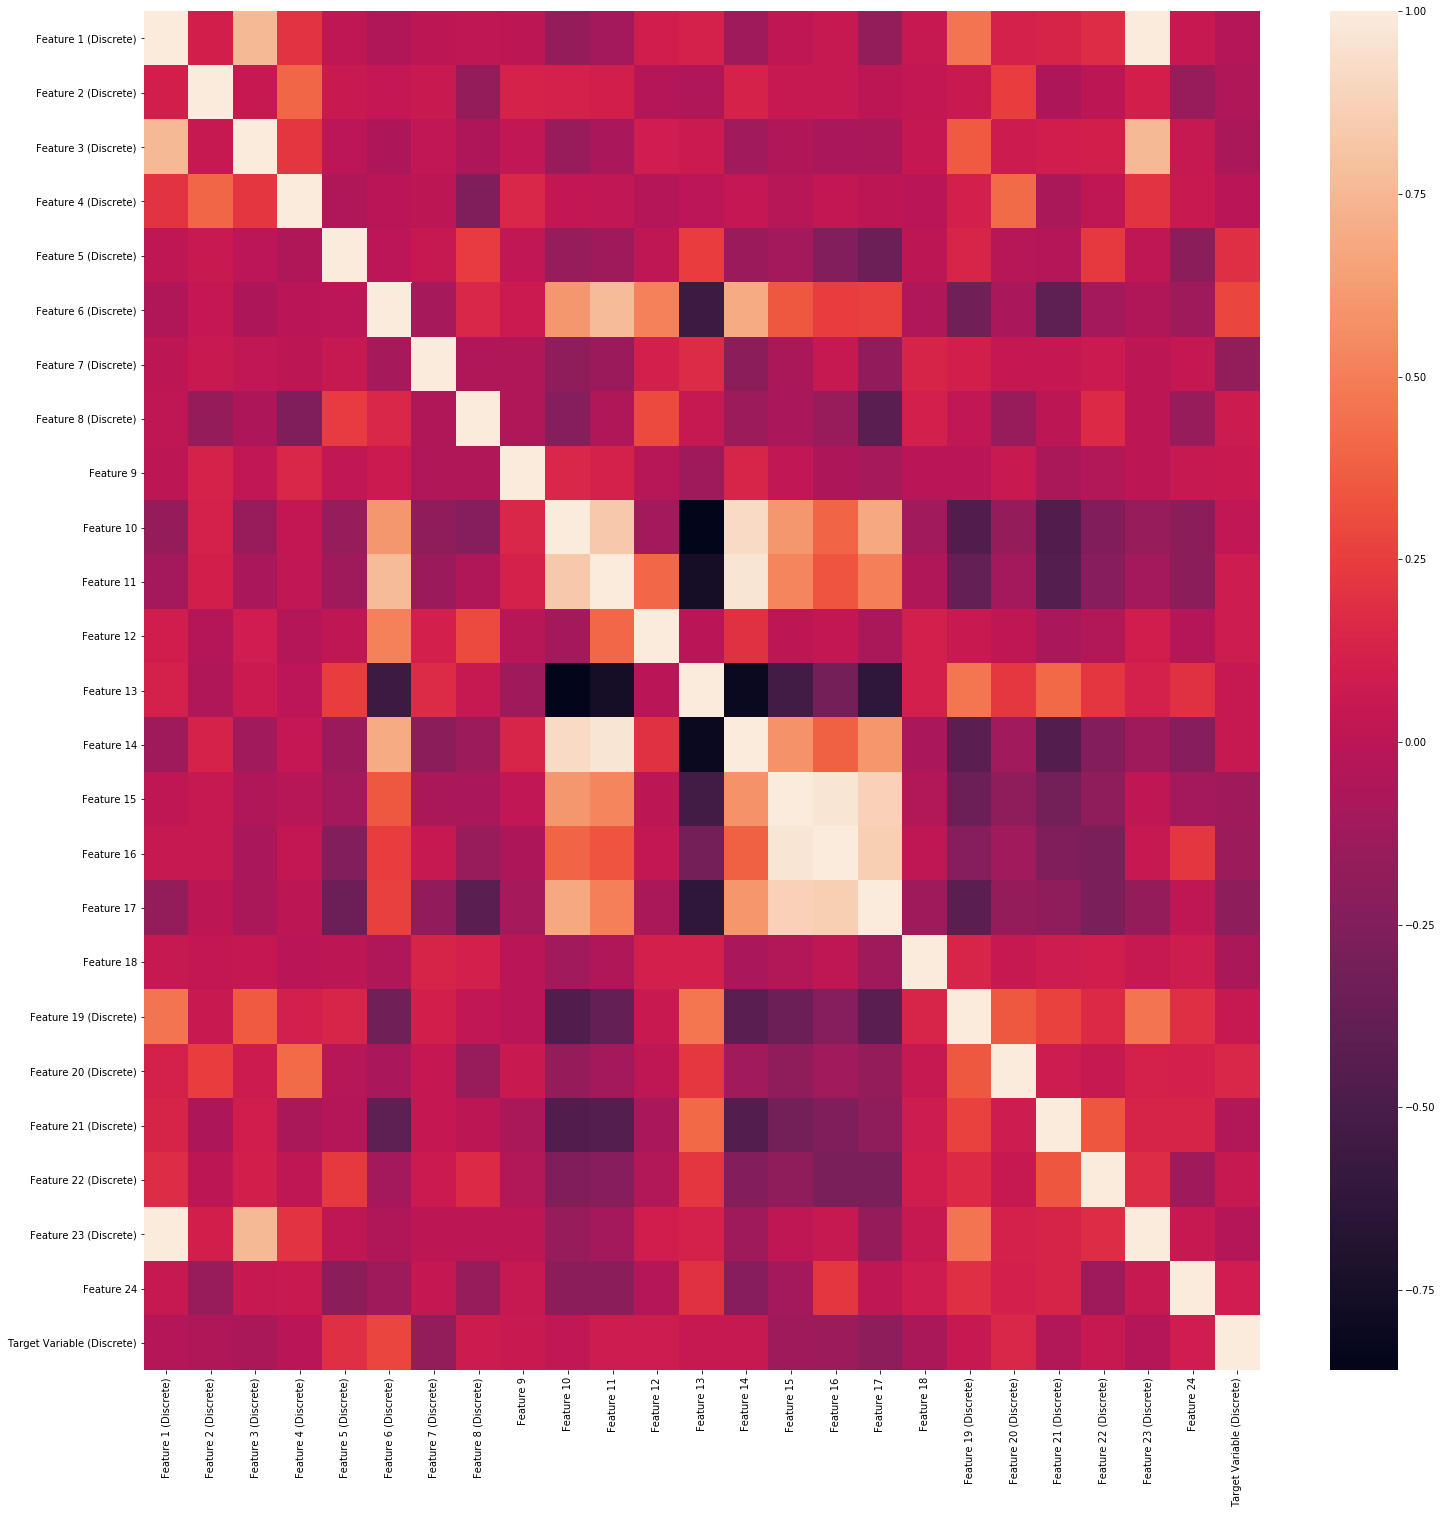

In [25]:
plt.figure(figsize=(25,25))
sns.heatmap(train.corr())

In [42]:
#### Removing outliers..


def remove_outliers(df,r = 3):
    outfree = df[(np.abs(stats.zscore(df)) < r).all(axis=1)]
    return outfree


In [51]:
train_outfree = remove_outliers(imputed_train,r = 5)
print(train.shape)
print(train_outfree.shape)

(994, 25)
(913, 25)
